This notebook is basically a copy of notebook 12, but with combining the loss with our "Random Layout" Predictor

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor, get_random_initial_position
# from lion_pytorch import Lion
from datetime import datetime
import random
from huggingface_hub import hf_hub_download
import timm
import torch.nn as nn

In [2]:
# Transformations
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
device = "cpu"

In [4]:
# Load pre-trained ResNet model
random_predictor = timm.create_model('resnet50', pretrained=True)
random_predictor.fc = nn.Linear(random_predictor.fc.in_features, 2)  # Modify the classifier to output 2 classes
random_predictor.to(device)

local_filename = hf_hub_download(repo_id="mowoe/random-layout-classifier", filename="random-layout-classifier.pt")
random_predictor.load_state_dict(torch.load(local_filename, map_location="cpu"))

<All keys matched successfully>

In [5]:
im = Image.open('../combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open('../combined/5373.json', "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]

In [6]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys() and "resource-id" in item.keys():
        all_boxes.append((item["bounds"],item["resource-id"]))
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes

In [7]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            # initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_theta = get_random_initial_position(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(1.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        segments_on_canvas.append(background)
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)



        return segments_on_canvas

In [8]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -6.2446,   0.5597],
        [  0.3235,   0.2849],
        [ -0.3852,  -2.4763],
        [  1.2702,  27.4931],
        [  1.7642,   8.5428],
        [  0.0000, -11.5621],
        [  0.0000, -23.4594]], dtype=torch.float64, requires_grad=True)


/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


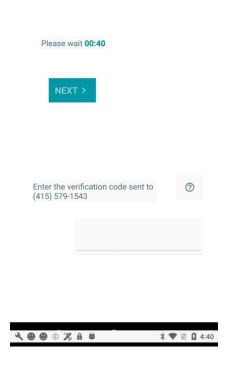

In [9]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))

plt.axis('off')
plt.show()

In [10]:
appsthetics_predictor = torch.load("../Dataset_estetica/Regressao//model123")

In [11]:
optimizer = torch.optim.AdamW(msUIo_wbg.parameters(), lr=0.1)

In [12]:
random_classifier_criterion = nn.CrossEntropyLoss()

In [13]:
random_classifier_loss_weight = 0.7
random_classifier_target = torch.Tensor([1.0]).to(torch.long)

In [ ]:
scores = []
random_losses = []
combined_losses = []
images_for_gif = []

for x in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = appsthetics_predictor["model"](generated_image.unsqueeze(0))
    print(f"Aesthetics Score: {score.detach().item()} (Loss: {1- score.detach().item()})")

    random_classifier_logits = random_predictor(resnet_transform(generated_image.unsqueeze(0)))
    random_loss = random_classifier_criterion(random_classifier_logits,random_classifier_target)
    print(f"Random Layout Loss: {random_loss.detach().item()}")
    random_losses.append(random_loss.detach().item())

    combined_loss = random_classifier_loss_weight * random_loss + (1-random_classifier_loss_weight) * (1-score)
    combined_losses.append(combined_loss.detach().item())

    print(f"Combined Layout and Aesthetics Loss: {combined_loss.detach().item()}")

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.detach().item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"output/{x}.png")
    images_for_gif.append(f"output/{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Aesthetics Score: 0.6016340851783752 (Loss: 0.39836591482162476)
Random Layout Loss: 3.581174850463867
Combined Layout and Aesthetics Loss: 2.6263320446014404


  0%|          | 1/1000 [00:09<2:39:48,  9.60s/it]

Aesthetics Score: 0.6009206771850586 (Loss: 0.3990793228149414)
Random Layout Loss: 3.6323633193969727
Combined Layout and Aesthetics Loss: 2.6623780727386475


  0%|          | 2/1000 [00:17<2:21:15,  8.49s/it]

Aesthetics Score: 0.5949084758758545 (Loss: 0.4050915241241455)
Random Layout Loss: 3.0320844650268555
Combined Layout and Aesthetics Loss: 2.2439866065979004


  0%|          | 3/1000 [00:25<2:21:04,  8.49s/it]

Aesthetics Score: 0.4900328516960144 (Loss: 0.5099671483039856)
Random Layout Loss: 3.329530954360962
Combined Layout and Aesthetics Loss: 2.483661651611328


  0%|          | 4/1000 [00:33<2:17:08,  8.26s/it]

Aesthetics Score: 0.4878913164138794 (Loss: 0.5121086835861206)
Random Layout Loss: 3.501333475112915
Combined Layout and Aesthetics Loss: 2.6045660972595215


  0%|          | 5/1000 [00:41<2:13:35,  8.06s/it]

Aesthetics Score: 0.5779858827590942 (Loss: 0.42201411724090576)
Random Layout Loss: 3.666487693786621
Combined Layout and Aesthetics Loss: 2.693145751953125


  1%|          | 6/1000 [00:48<2:09:27,  7.81s/it]

Aesthetics Score: 0.5276914834976196 (Loss: 0.47230851650238037)
Random Layout Loss: 3.52720046043396
Combined Layout and Aesthetics Loss: 2.6107330322265625


  1%|          | 7/1000 [00:56<2:07:09,  7.68s/it]

Aesthetics Score: 0.5318170189857483 (Loss: 0.4681829810142517)
Random Layout Loss: 3.0345726013183594
Combined Layout and Aesthetics Loss: 2.264655828475952


  1%|          | 8/1000 [01:03<2:04:44,  7.54s/it]

Aesthetics Score: 0.5539804697036743 (Loss: 0.4460195302963257)
Random Layout Loss: 2.581747531890869
Combined Layout and Aesthetics Loss: 1.9410290718078613


  1%|          | 9/1000 [01:10<2:03:24,  7.47s/it]

Aesthetics Score: 0.5586841106414795 (Loss: 0.4413158893585205)
Random Layout Loss: 2.915565252304077
Combined Layout and Aesthetics Loss: 2.173290491104126


  1%|          | 10/1000 [01:17<1:59:24,  7.24s/it]

Aesthetics Score: 0.5667179226875305 (Loss: 0.4332820773124695)
Random Layout Loss: 2.3557181358337402
Combined Layout and Aesthetics Loss: 1.7789872884750366


  1%|          | 11/1000 [01:24<1:56:28,  7.07s/it]

Aesthetics Score: 0.6061891913414001 (Loss: 0.39381080865859985)
Random Layout Loss: 3.722154140472412
Combined Layout and Aesthetics Loss: 2.723651170730591


  1%|          | 12/1000 [01:30<1:54:50,  6.97s/it]

Aesthetics Score: 0.5758166909217834 (Loss: 0.42418330907821655)
Random Layout Loss: 3.5910308361053467
Combined Layout and Aesthetics Loss: 2.6409764289855957


  1%|▏         | 13/1000 [01:37<1:54:21,  6.95s/it]

Aesthetics Score: 0.5202963948249817 (Loss: 0.4797036051750183)
Random Layout Loss: 2.8740527629852295
Combined Layout and Aesthetics Loss: 2.155748128890991


  1%|▏         | 14/1000 [01:44<1:54:15,  6.95s/it]

Aesthetics Score: 0.5551280975341797 (Loss: 0.4448719024658203)
Random Layout Loss: 3.114952325820923
Combined Layout and Aesthetics Loss: 2.3139281272888184


  2%|▏         | 15/1000 [01:51<1:54:36,  6.98s/it]

Aesthetics Score: 0.6232478618621826 (Loss: 0.3767521381378174)
Random Layout Loss: 3.358609914779663
Combined Layout and Aesthetics Loss: 2.464052677154541


  2%|▏         | 16/1000 [01:58<1:53:54,  6.95s/it]

Aesthetics Score: 0.5939460396766663 (Loss: 0.40605396032333374)
Random Layout Loss: 3.427553653717041
Combined Layout and Aesthetics Loss: 2.521103620529175


  2%|▏         | 17/1000 [02:05<1:55:12,  7.03s/it]

Aesthetics Score: 0.638287365436554 (Loss: 0.36171263456344604)
Random Layout Loss: 3.632274627685547
Combined Layout and Aesthetics Loss: 2.651106119155884


  2%|▏         | 18/1000 [02:13<1:57:37,  7.19s/it]

Aesthetics Score: 0.580834150314331 (Loss: 0.41916584968566895)
Random Layout Loss: 3.5122053623199463
Combined Layout and Aesthetics Loss: 2.5842936038970947


  2%|▏         | 19/1000 [02:20<1:57:05,  7.16s/it]

Aesthetics Score: 0.598147988319397 (Loss: 0.401852011680603)
Random Layout Loss: 3.2607996463775635
Combined Layout and Aesthetics Loss: 2.4031152725219727


  2%|▏         | 20/1000 [02:27<1:56:05,  7.11s/it]

Aesthetics Score: 0.6000429391860962 (Loss: 0.3999570608139038)
Random Layout Loss: 3.027582883834839
Combined Layout and Aesthetics Loss: 2.23929500579834


  2%|▏         | 21/1000 [02:34<1:55:20,  7.07s/it]

Aesthetics Score: 0.6156602501869202 (Loss: 0.38433974981307983)
Random Layout Loss: 4.132167816162109
Combined Layout and Aesthetics Loss: 3.007819175720215


  2%|▏         | 22/1000 [02:41<1:54:11,  7.01s/it]

Aesthetics Score: 0.5663506984710693 (Loss: 0.43364930152893066)
Random Layout Loss: 3.0194742679595947
Combined Layout and Aesthetics Loss: 2.2437267303466797


  2%|▏         | 23/1000 [02:47<1:51:43,  6.86s/it]

Aesthetics Score: 0.5521169900894165 (Loss: 0.4478830099105835)
Random Layout Loss: 2.9128637313842773
Combined Layout and Aesthetics Loss: 2.1733694076538086


  2%|▏         | 24/1000 [02:54<1:51:52,  6.88s/it]

Aesthetics Score: 0.6128668785095215 (Loss: 0.3871331214904785)
Random Layout Loss: 3.4780406951904297
Combined Layout and Aesthetics Loss: 2.5507683753967285


  2%|▎         | 25/1000 [03:01<1:52:59,  6.95s/it]

Aesthetics Score: 0.5690774321556091 (Loss: 0.43092256784439087)
Random Layout Loss: 3.5849294662475586
Combined Layout and Aesthetics Loss: 2.6387274265289307


  3%|▎         | 26/1000 [03:08<1:51:54,  6.89s/it]

Aesthetics Score: 0.5654674768447876 (Loss: 0.4345325231552124)
Random Layout Loss: 3.281555414199829
Combined Layout and Aesthetics Loss: 2.4274487495422363


  3%|▎         | 27/1000 [03:15<1:51:05,  6.85s/it]

Aesthetics Score: 0.5768234133720398 (Loss: 0.4231765866279602)
Random Layout Loss: 3.9979937076568604
Combined Layout and Aesthetics Loss: 2.925548553466797


  3%|▎         | 28/1000 [03:21<1:48:42,  6.71s/it]

Aesthetics Score: 0.5737861394882202 (Loss: 0.4262138605117798)
Random Layout Loss: 3.634592294692993
Combined Layout and Aesthetics Loss: 2.6720786094665527


  3%|▎         | 29/1000 [03:28<1:46:41,  6.59s/it]

Aesthetics Score: 0.6060745716094971 (Loss: 0.39392542839050293)
Random Layout Loss: 3.2940573692321777
Combined Layout and Aesthetics Loss: 2.4240176677703857


  3%|▎         | 30/1000 [03:34<1:47:03,  6.62s/it]

Aesthetics Score: 0.6168786287307739 (Loss: 0.3831213712692261)
Random Layout Loss: 3.297271490097046
Combined Layout and Aesthetics Loss: 2.4230263233184814


  3%|▎         | 31/1000 [03:41<1:46:26,  6.59s/it]

Aesthetics Score: 0.6319061517715454 (Loss: 0.3680938482284546)
Random Layout Loss: 2.7350234985351562
Combined Layout and Aesthetics Loss: 2.024944543838501


  3%|▎         | 32/1000 [03:47<1:46:05,  6.58s/it]

Aesthetics Score: 0.5953508615493774 (Loss: 0.40464913845062256)
Random Layout Loss: 2.581610679626465
Combined Layout and Aesthetics Loss: 1.9285222291946411


  3%|▎         | 33/1000 [03:54<1:45:44,  6.56s/it]

Aesthetics Score: 0.6105397343635559 (Loss: 0.3894602656364441)
Random Layout Loss: 3.8708391189575195
Combined Layout and Aesthetics Loss: 2.826425313949585


  3%|▎         | 34/1000 [04:00<1:45:24,  6.55s/it]

Aesthetics Score: 0.5650537610054016 (Loss: 0.4349462389945984)
Random Layout Loss: 3.482773542404175
Combined Layout and Aesthetics Loss: 2.568425416946411


  4%|▎         | 35/1000 [04:07<1:46:11,  6.60s/it]

Aesthetics Score: 0.5589238405227661 (Loss: 0.4410761594772339)
Random Layout Loss: 3.0945935249328613
Combined Layout and Aesthetics Loss: 2.2985382080078125


  4%|▎         | 36/1000 [04:14<1:45:36,  6.57s/it]

Aesthetics Score: 0.5898662805557251 (Loss: 0.4101337194442749)
Random Layout Loss: 3.7330989837646484
Combined Layout and Aesthetics Loss: 2.7362093925476074


  4%|▎         | 37/1000 [04:20<1:45:01,  6.54s/it]

Aesthetics Score: 0.5743401050567627 (Loss: 0.4256598949432373)
Random Layout Loss: 3.7294108867645264
Combined Layout and Aesthetics Loss: 2.738285541534424


  4%|▍         | 38/1000 [04:27<1:44:39,  6.53s/it]

Aesthetics Score: 0.6233937740325928 (Loss: 0.3766062259674072)
Random Layout Loss: 3.7780537605285645
Combined Layout and Aesthetics Loss: 2.7576193809509277


  4%|▍         | 39/1000 [04:33<1:43:54,  6.49s/it]

Aesthetics Score: 0.620378851890564 (Loss: 0.37962114810943604)
Random Layout Loss: 3.754633665084839
Combined Layout and Aesthetics Loss: 2.7421298027038574


  4%|▍         | 40/1000 [04:40<1:43:53,  6.49s/it]

Aesthetics Score: 0.578726053237915 (Loss: 0.42127394676208496)
Random Layout Loss: 3.7163472175598145
Combined Layout and Aesthetics Loss: 2.727825164794922


  4%|▍         | 41/1000 [04:46<1:43:21,  6.47s/it]

Aesthetics Score: 0.6039543747901917 (Loss: 0.39604562520980835)
Random Layout Loss: 3.583829164505005
Combined Layout and Aesthetics Loss: 2.6274940967559814


  4%|▍         | 42/1000 [04:53<1:47:10,  6.71s/it]

Aesthetics Score: 0.5600000023841858 (Loss: 0.4399999976158142)
Random Layout Loss: 3.8124120235443115
Combined Layout and Aesthetics Loss: 2.8006882667541504


  4%|▍         | 43/1000 [05:00<1:46:06,  6.65s/it]

Aesthetics Score: 0.6234176754951477 (Loss: 0.3765823245048523)
Random Layout Loss: 3.1372005939483643
Combined Layout and Aesthetics Loss: 2.3090150356292725


  4%|▍         | 44/1000 [05:06<1:45:26,  6.62s/it]

Aesthetics Score: 0.6118576526641846 (Loss: 0.38814234733581543)
Random Layout Loss: 3.515714168548584
Combined Layout and Aesthetics Loss: 2.5774426460266113


  4%|▍         | 45/1000 [05:13<1:44:36,  6.57s/it]

Aesthetics Score: 0.5933145880699158 (Loss: 0.40668541193008423)
Random Layout Loss: 3.3478715419769287
Combined Layout and Aesthetics Loss: 2.4655158519744873


  5%|▍         | 46/1000 [05:19<1:44:08,  6.55s/it]

Aesthetics Score: 0.5838195085525513 (Loss: 0.41618049144744873)
Random Layout Loss: 3.5483829975128174
Combined Layout and Aesthetics Loss: 2.60872220993042


  5%|▍         | 47/1000 [05:26<1:43:40,  6.53s/it]

Aesthetics Score: 0.532031238079071 (Loss: 0.46796876192092896)
Random Layout Loss: 3.6817030906677246
Combined Layout and Aesthetics Loss: 2.7175827026367188


  5%|▍         | 48/1000 [05:33<1:45:24,  6.64s/it]

Aesthetics Score: 0.620650053024292 (Loss: 0.379349946975708)
Random Layout Loss: 3.412724018096924
Combined Layout and Aesthetics Loss: 2.502711772918701


  5%|▍         | 49/1000 [05:39<1:45:36,  6.66s/it]

Aesthetics Score: 0.6380822658538818 (Loss: 0.36191773414611816)
Random Layout Loss: 3.622945785522461
Combined Layout and Aesthetics Loss: 2.6446373462677


  5%|▌         | 50/1000 [05:46<1:46:18,  6.71s/it]

Aesthetics Score: 0.6699250936508179 (Loss: 0.33007490634918213)
Random Layout Loss: 3.59797739982605
Combined Layout and Aesthetics Loss: 2.6176066398620605


  5%|▌         | 51/1000 [05:53<1:46:52,  6.76s/it]

Aesthetics Score: 0.6085124015808105 (Loss: 0.39148759841918945)
Random Layout Loss: 3.278292179107666
Combined Layout and Aesthetics Loss: 2.4122507572174072


In [ ]:
plt.plot(scores)
plt.show()

In [ ]:
plt.plot(random_losses)
plt.show()

In [ ]:
plt.plot(combined_losses)
plt.show()

In [ ]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))